# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Task Description**

In task 1 of this notebook we are going to perform a sentiment analysis of hotel reviews. We are going to build 4 different machine learning models to predict and classify the sentiment of the reviews (positive or negative). The notebook is ordered in different sections, where we first load the data, explore the dataset to gain an understanding of it, perform data cleaning and preprocessing, feature extraction, and finally build and evaluate the machine learning models.

## **Importing necessary libraries**

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_recall_curve, average_precision_score, make_scorer, f1_score
)
import mglearn
from random import randint

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import time


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from scikeras.wrappers import KerasClassifier

## **Helper functions**

This section contains helper functions that will be used throughout the notebook, spesifically for visualizing the data and the models.

### **Helper function for heatmap visualization**

In [49]:
def plot_gridsearch_heatmap(grid, param_grid, x_param, y_param, score_metric='mean_test_score', cmap='viridis'):
    n_x = len(param_grid[x_param])
    n_y = len(param_grid[y_param])

    scores = np.array(grid.cv_results_[score_metric][:n_x * n_y]).reshape(n_y, n_x)

    plt.figure(figsize=(10, 6))
    sns.heatmap(scores, annot=True, fmt=".3f", 
                xticklabels=param_grid[x_param], 
                yticklabels=param_grid[y_param], 
                cmap=cmap)
    
    plt.xlabel(x_param.split('__')[-1]) 
    plt.ylabel(y_param.split('__')[-1])
    plt.title(f"Heatmap of GridSearch {score_metric}")
    plt.show()

### **Helper function for Precision-Recall curve visualization**

In [50]:
def plot_precision_recall_curve(y_test, y_scores, sentiment):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP Score = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {sentiment} sentiment')
    plt.legend()
    plt.show()

### **Helper function for visualizing the top features that are most indicative of positive and negative sentiment of reviews**

In [51]:
def visualize_top_features(grid, X_train, classifier_step, vectorizer_step="tfidfvectorizer", n_features=20, n_top_coef=40):
    
    # Extract the best vectorizer and transform training data
    vectorizer = grid.best_estimator_.named_steps[vectorizer_step]
    X_train_transformed = vectorizer.transform(X_train)

    # Compute max TF-IDF value for each feature
    max_value = X_train_transformed.max(axis=0).toarray().ravel()
    sorted_by_tfidf = max_value.argsort()

    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Print features with lowest and highest TF-IDF values
    print("Features with lowest TF-IDF:\n{}".format(feature_names[sorted_by_tfidf[:n_features]]))
    print("\nFeatures with highest TF-IDF:\n{}".format(feature_names[sorted_by_tfidf[-n_features:]]))

    # Extract log probabilities from the classifier
    classifier = grid.best_estimator_.named_steps[classifier_step]
    log_probabilities = classifier.feature_log_prob_

    # Compute coefficient differences (importance per class)
    coef_diff = log_probabilities[1] - log_probabilities[0]

    # Visualize the top coefficients
    mglearn.tools.visualize_coefficients(coef_diff, feature_names, n_top_features=n_top_coef)

## **Load data**

In [52]:
df = pd.read_csv('dataset/Hotel_Reviews.csv')
# Creating a copy of the dataframe to preserve the original data for visualization 
df_copy = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the dataset**

### **Exploring the basic structure of the dataset**

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

The cell above shows some info about the dataset. We can see that the dataset in total contains 515,738 rows (reviews) and 17 columns containing both numerical and categorical data. We can also observe that there are some missing values, specifically in the columns "lat" and "lng" where non-null count is 512,470 out of 515,738. This means there are 3,268 missing values in these columns. All other columns have no missing values, as indicated by the "non-null" count being the same as the total row count (515,738).

For the sentiment analysis, we interpret the column Reviewer_Score as the most suitable label for the sentiment of the review. This is because the review score is a numerical value that can be used to classify the sentiment of the review as positive or negative. Assuming that higher numerical values reflect more positive reviews and lower scores reflect more negative reviews, we can use a threshold to classify reviews into "positive" or "negative" reviews. 
 

In [54]:
df[df['lat'].isna()].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
99488,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No Negative,0,377,Upgraded rooms are excellent Good size for tr...,25,6,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99489,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Noise Not being told about this when we check...,12,377,The location was great However renovations we...,45,1,6.7,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99490,20 Rue De La Ga t 14th arr 75014 Paris France,22,7/25/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,Room was worn down One of the curtains did no...,43,377,Location was good,5,1,5.4,"[' Leisure trip ', ' Solo traveler ', ' Standa...",9 days,NaN,NaN
99491,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,8.3,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,NaN,NaN
99492,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/24/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,The breakfast was way over priced and the sta...,83,377,The property was conveniently located near th...,11,2,5.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",71 days,NaN,NaN
99493,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/5/2017,7.8,Mercure Paris Gare Montparnasse,Belgium,Work in progress noise no bar keys had to be ...,39,377,Comfort,2,3,5.0,"[' Leisure trip ', ' Family with young childre...",90 days,NaN,NaN
99494,20 Rue De La Ga t 14th arr 75014 Paris France,22,2/11/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Max price for the bare minimum Acor Hotels ca...,67,377,Few minutes walk to Ga t Metro Montparnasse M...,46,20,5.8,"[' Business trip ', ' Couple ', ' Standard Roo...",173 day,NaN,NaN
99495,20 Rue De La Ga t 14th arr 75014 Paris France,22,12/5/2016,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Ongoing refurbishment whilst we were there,8,377,Very quiet at night couldn t believe we were ...,21,1,8.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",241 day,NaN,NaN
99496,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/30/2016,7.8,Mercure Paris Gare Montparnasse,France,We took a room for 3 the extra bed couch bed ...,23,377,Great location 5 min away from gare montparna...,32,34,8.3,"[' Leisure trip ', ' Family with young childre...",277 day,NaN,NaN
99497,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/11/2016,7.8,Mercure Paris Gare Montparnasse,United States of America,N A Room lacking microwave a minor inconvenie...,10,377,Great neighborhood with lots of restaurants s...,22,1,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",296 day,NaN,NaN


In the cell above, we check the first 10 rows of the dataset that contain NaN values in the lat columns, to check for any discrepancies in the data. As nothing stands out as strange in the reviews with missing values in the lat column, we do nothing, but also check (see cell below), just to be safe, that there are no rows with only NaN values in either the lat or lng column.

In [55]:
df[(df['lat'].isna()) & (df['lng'].notnull())].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng


In [56]:
df[(df['lat'].notnull()) & (df['lng'].isna())].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng


### **Overview of the distribution of the review scores** 

In [57]:
print(df['Reviewer_Score'].describe()) 

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64


The cell above shows a statistical summary of the target column in the dataset: Reviewer_Score.
* min = 2.5 means that the lowest score given by any reviewer is 2.5 and max = 10.0 that the highest is 10.
* mean = 8.4 show the average reviewer score, suggesting that most reviews are positive. 
* The std (standard deviation) = 1.6 shows that the reviewer scores are fairly consistent and do not vary significantly, but are close to the average score of 8.4.
* 25th percentile (Q1) = 7.5 → 25% of the reviews have a score below 7.5, meaning that the majority (75%) have a score above 7.5. This suggests that most of the scores are relatively high.
* 50th percentile (Median, Q2) = 8.8 → 50% of the reviews have a score below 8.8, and 50% have a score above 8.8. This shows that the median review score is quite high, reinforcing the idea that most reviews are positive.
* 75th percentile (Q3) = 9.6 → 75% of the reviews have a score below 9.6, meaning that 25% of the reviews are between 9.6 and 10, again indicating a strong concentration of high ratings.

**Key takeaway from the statistical summary:**
* The distribution is skewed towards positive reviews, as most scores are relatively high. This suggests that the dataset may be imbalanced, which is something we will need to consider when building our machine learning models. However, this is not suprising, as people tend to leave reviews when they have a strong opinion, often positive rather than neutral so it makes sense. 

### **Histogram and Boxplot showing the distribution of the review scores** 

<Axes: >

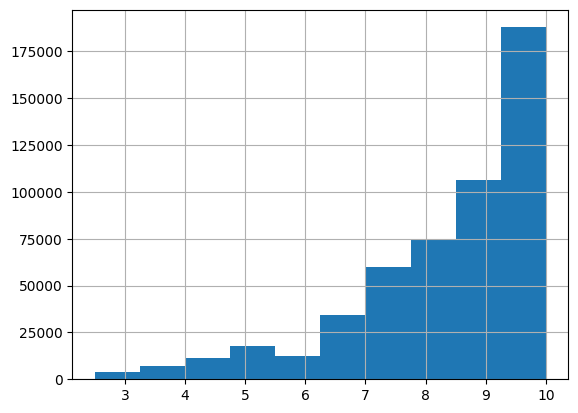

In [58]:
df['Reviewer_Score'].hist(bins=10)

In [59]:
print(df['Reviewer_Score'].value_counts(bins=10))

(9.25, 10.0]     187807
(8.5, 9.25]      105659
(7.75, 8.5]       75277
(7.0, 7.75]       59733
(6.25, 7.0]       34502
(4.75, 5.5]       18175
(5.5, 6.25]       12304
(4.0, 4.75]       11469
(3.25, 4.0]        6979
(2.491, 3.25]      3833
Name: count, dtype: int64


From the histogram over and the distribution of the review scores in each bin we can see that the distribution of the scores is skewed towards the higher scores. This is consistent with the statistical summary we saw earlier, where we observed that most of the scores are relatively high and the dataset is imbalanced. 

After understanding some basic information about the dataset, we can now move on to explore the reviews further 

## **Cleaning review texts and finding threshold**

After exploring the dataset we find that the columns "Negative_Review" and "Positive_Review" contain the review texts. We also see that there are many rows in these columns containing the words 'No Negative' and 'No Positive'. These words are placeholders for missing data. For example, a row containing 'No Negative' in the "Negative_Review" column means that the reviewer did not leave any negative comments and vice versa for 'No Positive'. We decide to replace these words with an empty string using a replace function because they are not relevant for the sentiment analysis, and will confuse our model, as we eventually plan to merge the 'Positive_Review' and 'Negative_Review' columns into one. 

#### **Attempt to find a limit for positive and negative reviews**
Before we replace the 'No Negative' and 'No Positive' strings with empty strings, we try to use them to our advantage by using them to try to find a limit for where to separate the positive and negative review scores. We do this by checking the distribution of the review scores for the reviews that contain 'No Negative' and 'No Positive' in the 'Negative_Review' and 'Positive_Review' columns.

In [60]:
# Here we check the mean and median scores of reviews that are blank, e.g. they contain both strings "No Negative" and "No Positive" in the columns "Negative_Review" and "Positive_Review" respectively.
none_mean = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].mean()
none_median = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].median()

# We also see how many reviews are blank 
amount_none = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')].shape[0]

# Here we check the mean and median scores of reviews that are positive, i.e. they contain the string "No Negative" in the column "Negative_Review" and do not contain the string "No Positive" in the column "Positive_Review".
positive_mean = df[df['Negative_Review'] == 'No Negative']['Reviewer_Score'].mean()
positive_median = df[df['Negative_Review'] == 'No Negative']['Reviewer_Score'].median()

# Here we check the mean and median scores of reviews that are negative, i.e. they contain the string "No Positive" in the column "Positive_Review" and do not contain the string "No Negative" in the column "Negative_Review".
negative_mean = df[df['Positive_Review'] == 'No Positive']['Reviewer_Score'].mean()
negative_median = df[df['Positive_Review'] == 'No Positive']['Reviewer_Score'].median()

print('Mean of no negative and no positive reviews:', none_mean)
print('Median of no negative and no positive reviews:', none_median)
print('Mean of positive reviews:', positive_mean)
print('Mean of negative reviews:', negative_mean)
print('Median of positive reviews:', positive_median)
print('Median of negative reviews:', negative_median)
print('Amount of reviews with no negative and no positive reviews:', amount_none)


Mean of no negative and no positive reviews: 8.285826771653543
Median of no negative and no positive reviews: 8.8
Mean of positive reviews: 9.338446321057159
Mean of negative reviews: 6.886666110276526
Median of positive reviews: 9.6
Median of negative reviews: 7.1
Amount of reviews with no negative and no positive reviews: 127


In [61]:
# Here we calculate the percentage of reviews that contain 'No Negative' in the 'Negative_Review' column and 'No Positive' in the 'Positive_Review' column

def percentage_of_reviews():
    no_negative = df[df['Negative_Review'] == 'No Negative'].shape[0]
    no_positive = df[df['Positive_Review'] == 'No Positive'].shape[0]
    total = df.shape[0]

    positive_percentage = no_negative / total * 100
    negative_percentage = no_positive / total * 100

    print('Percentage of clearly positive reviews:', positive_percentage)
    print('Percentage of clearly negative reviews:', negative_percentage)

percentage_of_reviews()

Percentage of clearly positive reviews: 24.797474686759557
Percentage of clearly negative reviews: 6.96981800836859


Interestingly, there are 127 reviews with no text at all, only the string 'No Negative' or 'No Positive'. These reviews have a mean score of 8,3, and a median csore of 8,8. This suggests that reviews with no text are generally positive, but not as positive as reviews with the string 'No Negative'. As they do not contain any text, we can not use them for training our model, and we will remove them from the dataset.

From the data we can see that 24,7 % of all reviews contain the string 'No Negative', and have a very high median score of 9,6 and a mean score of 9,3. This suggests that reviews containing the string 'No Negative' are generally extremely positive.

On the other hand, 7 % of all reviews contain the string 'No Positive', and have a median score of 7,1 and a mean score of 6,9. This suggests that reviews containing the string 'No Positive', generally score very high as well, but not as high as reviews containing the string 'No Negative'. This can pinpoint that we should consider marking reviews with a score above 7,1 as positive, and reviews with a score below and including 7,1 as negative. 

We can plot the relationship between the amount of positive words and reviewer score as a function, and compare it to the relationship between the amount of negative words and reviewer score, and find a crossing point between them to further pinpoint where we should separate the scores into positive and negative.

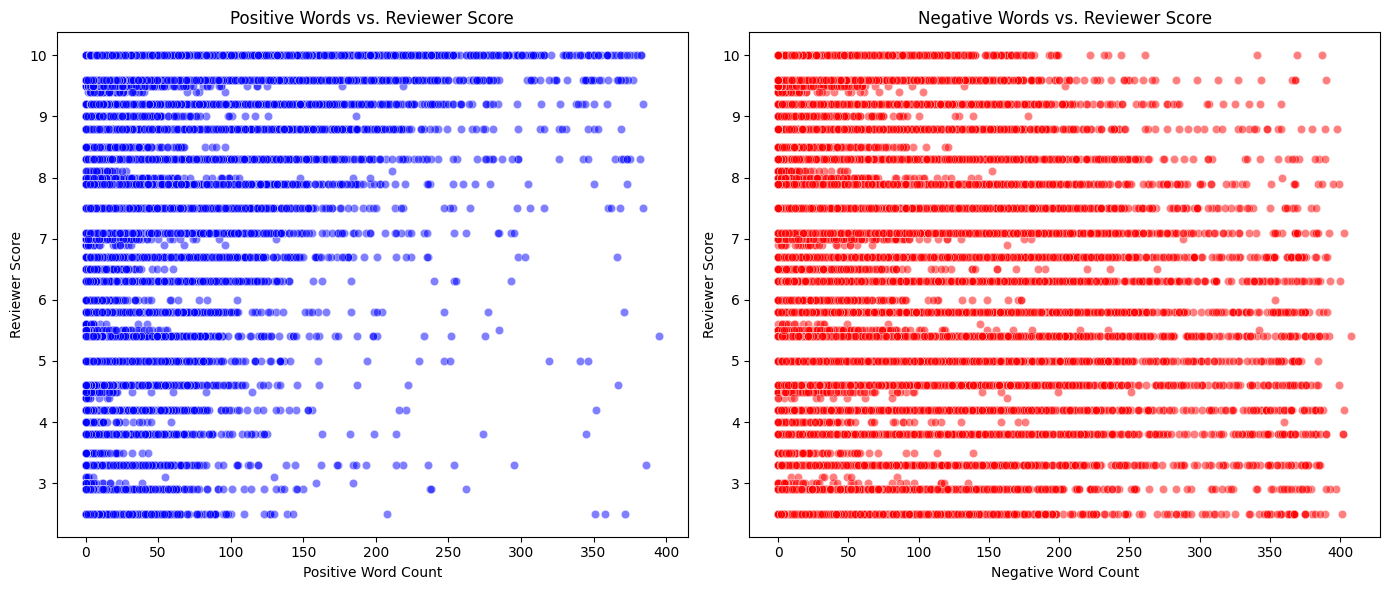

Intersection point: x = 18.21, y = 8.40


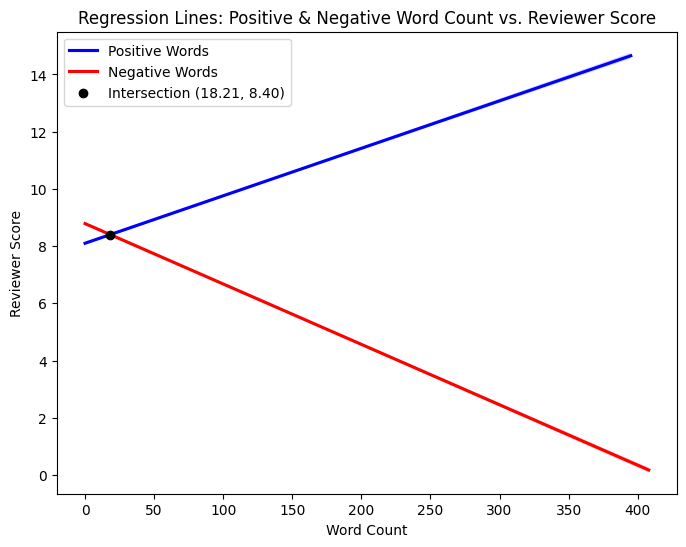

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def find_intersection(df):
    """Finds the intersection of the regression lines for positive and negative word counts."""
    X_pos = df[['pos_count']].values
    X_neg = df[['neg_count']].values
    y = df['Reviewer_Score'].values

    # Fit linear regression models
    model_pos = LinearRegression().fit(X_pos, y)
    model_neg = LinearRegression().fit(X_neg, y)

    # Get slopes (m) and intercepts (b)
    m1, b1 = model_pos.coef_[0], model_pos.intercept_
    m2, b2 = model_neg.coef_[0], model_neg.intercept_

    # Solve for intersection: m1*x + b1 = m2*x + b2  ->  x = (b2 - b1) / (m1 - m2)
    if m1 != m2:  # Avoid division by zero
        x_intersect = (b2 - b1) / (m1 - m2)
        y_intersect = m1 * x_intersect + b1
        return x_intersect, y_intersect
    else:
        return None  # Parallel lines (no intersection)

def plot_sentiment_vs_score(df):
    """Plots scatter plots separately and regression lines together with intersection point."""
    df[['pos_count', 'neg_count']] = df[['Review_Total_Positive_Word_Counts', 'Review_Total_Negative_Word_Counts']]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot for positive words vs. reviewer score
    sns.scatterplot(x=df['pos_count'], y=df['Reviewer_Score'], ax=axes[0], alpha=0.5, color="blue")
    axes[0].set_title("Positive Words vs. Reviewer Score")
    axes[0].set_xlabel("Positive Word Count")
    axes[0].set_ylabel("Reviewer Score")

    # Scatter plot for negative words vs. reviewer score
    sns.scatterplot(x=df['neg_count'], y=df['Reviewer_Score'], ax=axes[1], alpha=0.5, color="red")
    axes[1].set_title("Negative Words vs. Reviewer Score")
    axes[1].set_xlabel("Negative Word Count")
    axes[1].set_ylabel("Reviewer Score")

    plt.tight_layout()
    plt.show()

    # Find intersection
    intersection = find_intersection(df)

    # Regression lines on the same plot
    plt.figure(figsize=(8, 6))
    sns.regplot(x=df['pos_count'], y=df['Reviewer_Score'], scatter=False, line_kws={'color':'blue'}, label="Positive Words")
    sns.regplot(x=df['neg_count'], y=df['Reviewer_Score'], scatter=False, line_kws={'color':'red'}, label="Negative Words")

    # Plot intersection if it exists
    if intersection:
        x_int, y_int = intersection
        plt.scatter(x_int, y_int, color="black", zorder=3, label=f"Intersection ({x_int:.2f}, {y_int:.2f})")
        print(f"Intersection point: x = {x_int:.2f}, y = {y_int:.2f}")

    plt.title("Regression Lines: Positive & Negative Word Count vs. Reviewer Score")
    plt.xlabel("Word Count")
    plt.ylabel("Reviewer Score")
    plt.legend()
    plt.show()

plot_sentiment_vs_score(df)


As the regression lines show, the general trend for positive words is that the more positive words are used, the higher the score. The opposite is true for negative words: the more negative words are used, the lower the score. This is a clear indication that the sentiment of the reviews is correlated with the reviewer score, and gives us an indication of where the separation between positive and negative reviews should be drawn. According to the plot, it should be around 8,40 in score. 

In [ ]:
# Count how many reviews contain the strings "No Negative" and "No Positive" in the columns "Negative_Review" and "Positive_Review" respectively
def count_reviews():
    no_negative = 0
    no_positive = 0
    for review in df['Negative_Review']:
        if "No Negative" in review and review != 'No Negative':
            no_negative += 1

    for review in df['Positive_Review']:
        if "No Positive" in review and review != 'No Positive':
            no_positive += 1

    return no_negative, no_positive

print(count_reviews())

print("Removing 'No Negative' and 'No Positive' reviews...")


df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x if x != 'No Negative' else '')
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x if x != 'No Positive' else '')

# Confirm that the replacements were successful and did not remove occurences of the strings "No Negative" and "No Positive" in ordinary reviews
print(count_reviews())
percentage_of_reviews()

df = df[(df['Negative_Review'] != '') | (df['Positive_Review'] != '')]

(3, 0)
(3, 0)
Percentage of clearly positive reviews: 0.0
Percentage of clearly negative reviews: 0.0


Interestingly, there appears to be only 3 reviews that contain the string "No Negative" in the reviews themselves. 

In [ ]:
for review in df['Negative_Review']:
    if "No Negative" in review and review != 'No Negative':
        print(review + str(df[df['Negative_Review'] == review]['Reviewer_Score'].values[0]))

 No Negative Points Everything great 9.6
 No Negative comments only that we wish we could have stayed there longer And giving it a 10 rating is selling the hotel short in my eyes 10.0
 No Negatives from us only Thumbs Up 10.0


These reviews are clearly extremely positive, and there seems to be no real danger in letting them remain in the dataset.

## **Exploring Swedish reviews**

After initially exploring the dataset, we have discovered that there are a lot of reviews where the reviews themselves fully/partly consist of foreign languages. This will be a problem for our model as we base it on the english language. We notice that the swedes especially enjoy writing in their native language, and we concentrate on reviews by swedes.

In [17]:
print(df_copy['Reviewer_Nationality'].value_counts()[' Sweden '])

df_copy['Review'] = df_copy['Negative_Review'] + ' ' + df_copy['Positive_Review']

3368


In the cell above we get a count of how many reviews are written by people with Swedish nationality, and decide to combine the 'Negative_Review' and 'Positive_Review' columns into one column called 'Review' because it makes it easier to work with the data and we use this column in the cell below to print out specific swedish reviews.

In [18]:
print('1.' + df_copy.loc[224965, 'Review'] + '\n')
print('2.' + df_copy.loc[102335, 'Review'] + '\n')
print('3.' + df_copy.loc[514238, 'Review'] + '\n')
print('4.' + df_copy.loc[44876, 'Review'] + '\n')
print('5.' + df_copy.loc[381438, 'Review'] + '\n')

1. Rummet var litet Toalett utan handfat Tr ngt badrum D lig frukost utan gr nsaker Liten pool i ett annat hus S sm f rvaringssk p   Bra l ge N ra till Eiffeltornet floden och nya k pcentrum 

2. H rd s ng var enda minus under vistelsen   Utm rkt l ge p hotellet Kort g avst nd fr n tinnelbanan och bussen alldeles utanf r d rren Ett extra plus var att en buss gick direkt till westfield gallerian med shopping i m ngder 

3. Sv rt att f rst och g ra sig f rst dd hos personalen vars engelska ibland var v ldigt bristf llig   J ttegod frukost med stort utbud 

4. S ngarna var f r h rda i min smak Omgivningarna best r av nyare byggnader med m nga kontorshus s det r inte s charmig del av London   Trevlig v lst dat rum i engelsk stil Fint badrum Ett plus att man dagligen fick tv l och tv vatten i kylsk pet gratis Mycket positiv och trevlig personal i matsalen Frukosten var bra eftersom man fick v lja ett varmt alternativ fr n menyn annars hade det blivit lite magert med enbart buffe N ra till t

So there are 3368 reviews written by Swedes and as we can see some of them are written in a strange, confusing way with a lot of nonsense words.

Before we potentially remove these reviews, we want to get some insight into the sentiment of the words the swedes use in their reviews. This is done to see if the swedish reviews tend to be more positive or negative. We do this by exploring the column "Review_Total_Positive_Word_Counts", and "Review_Total_Negative_Word_Counts". With these columns, we can calculate the sum of positive and negative words used in the swedish reviews.

In [19]:
swedish_reviews = df_copy[df_copy['Reviewer_Nationality'] == ' Sweden ']
total_negative_words = swedish_reviews['Review_Total_Negative_Word_Counts'].sum()
total_positive_words = swedish_reviews['Review_Total_Positive_Word_Counts'].sum()

print('Total number of negative words in Swedish reviews:', total_negative_words)
print('Total number of positive words in Swedish reviews:', total_positive_words)

Total number of negative words in Swedish reviews: 72640
Total number of positive words in Swedish reviews: 64246


As we can see from the cell above, the swedish reviews tend to use positive and negative words relatively equally. However, we decide to remove the swedish reviews from the dataset as they are written in a confusing way and contain a lot of nonsense words. This is not a huge loss for our dataset of around 500 000, and we believe that the model will perform better without these reviews.

In [20]:
df = df[df['Reviewer_Nationality'] != ' Sweden ']

## **Transforming review scores to binary values**

Here we add a new column called 'Sentiment' which is 1 if the reviewer score is greater than 7,1 and 0 if the reviewer score is less than or equal to 7,1. This is done to transform the review scores from coninuous numerical values into binary values, where 1 represents a positive review and 0 represents a negative review. We choose 7,1 as the threshold because it is the median score for reviews containing the string 'No Positive'. Heavy weight is placed on this value as it would seem that having nothing positive to say about a hotel, but only negative things is a strong indicator of a negative review. 

In [21]:
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 7.1 else 0)

print(df['Sentiment'].value_counts())
print(df['Sentiment'].value_counts(normalize=True) * 100)

Sentiment
1    425675
0     86568
Name: count, dtype: int64
Sentiment
1    83.100208
0    16.899792
Name: proportion, dtype: float64


From the value counts of the 'Sentiment' column we can again see that the dataset is imbalanced, with approximately 80% of the reviews being positive and approximately 20% being negative. 

In many cases now we have seen that the dataset is imbalanced, and skewed towards positive reviews and a minority of negative reviews. Anyhow, we choose to leave the dataset as it is. This is because the goal is to develop models that reflects the natural distribution of reviews, so keeping the dataset imbalanced makes sense. A model trained on the original distribution will align better with real-world expectations, where most reviews are positive.
Balancing the dataset by oversampling the minority class (negative reviews) or downsampling the majority class (positive reviews) can help improve the model’s ability to recognize negative reviews. However, it can also introduce artifacts and unusual patterns that make the dataset less representative of reality. This could lead to models that do not generalize well when applied to real-world data.
The trade-off we make by keeping the dataset imbalanced is that the models may be biased towards the majority class, predicting positive reviews more often. However, if this reflects the actual distribution of reviews, it may not necessarily be a problem.

## **Preprocessing the review text**

### **Stopwords removal**

A very important part of text preprocessing is the removal of stopwords because these words do not carry any sentiment value.

In [22]:
stop = stopwords.words('english')

def most_common_words(text):
    words = dict()
    for word in text:
        for w in word.split():
            if w in words and w != '':
                words[w] += 1
            else:
                words[w] = 1
    words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
    return list(words.keys())[:10]

most_common_positive = most_common_words(df['Positive_Review'])
most_common_negative = most_common_words(df['Negative_Review'])

print('Most common words in positive reviews:')
print(most_common_positive)
print('\n')
print('Most common words in negative reviews:')
print(most_common_negative)

Most common words in positive reviews:
['and', 'the', 'was', 'to', 'The', 'a', 'staff', 'very', 'location', 'room']


Most common words in negative reviews:
['the', 'was', 'to', 'a', 'and', 'in', 'room', 'of', 'for', 'not']


Here we can see that the most common words in both the positive and negative reviews are stopwords. This is not surprising, as stopwords are common words. But they do not carry any sentiment value, and should be removed. We will remove the stopwords from the reviews by using the NLTK library, and then again explore the 10 most common words in both columns to see if any additional stopwords should be removed. 

When removing the stopwords we also make sure to not remove the words 'no', 'not' and 'never' as they are important for sentiment analysis, as they are negation words and can drastically change the sentiment and meaning of a sentence.

In [23]:
stopwords_removed = dict()

def remove_stopwords_and_count(text):
    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in stop or word.lower() in ['no', 'not', 'never']])
    for word in text.split():
        if word.lower() in stop and word.lower() not in ['no', 'not', 'never']:
            if word.lower() in stopwords_removed:
                stopwords_removed[word.lower()] += 1
            else:
                stopwords_removed[word.lower()] = 1
    return cleaned_text

df['positive_review_cleaned'] = df['Positive_Review'].apply(lambda x: remove_stopwords_and_count(x))
df['negative_review_cleaned'] = df['Negative_Review'].apply(lambda x: remove_stopwords_and_count(x))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'could', 'would', 'Nothing']


We observe that after supposedly removing stopwords, we still have some stragglers that are not useful for our model, such as 'could' and 'would'. We will remove these as well as they are not useful for sentiment analysis.

In [24]:
def remove_specific_words(text, words):
    for word in words:
        text = text.replace(word, '')
    return text

df['positive_review_cleaned'] = df['positive_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))
df['negative_review_cleaned'] = df['negative_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords and specific words:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords and specific words:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords and specific words:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords and specific words:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'Nothing', 'rooms', 'bit']


We can observe that one of the most common words in the negative reviews is the word "Nothing", which appears alone and seems to indicate that the reviewer actually has nothing negative to say about the hotel, but instead of leaving it blank so the placeholder "No Negative" can appear, they have chosen to manually write "Nothing". This is a problem, as it is harder to sort out and replace these words with '', as they are common words used in very different sentences and contexts. 

In [25]:
no_negative = df[df['Negative_Review'].apply(lambda x: x.lower().strip() in ['no', 'nothing', 'none'])].shape[0]
no_positive = df[df['Positive_Review'].apply(lambda x: x.lower().strip() in ['no', 'nothing', 'none'])].shape[0]

print('Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column:', no_negative)
print('Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column:', no_positive)

Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column: 22827
Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column: 1802


We can observe that there are many reviews that only contain a negative word, suggesting that the reviewer has actually not written any review, and it will be most useful to just replace the text with ''. .

In [26]:
df['Negative_Review'] = df['Negative_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)
df['Positive_Review'] = df['Positive_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)

Now we need to make sure that there hasn't been created any rows with empty reviews. If there are, we remove them.

In [27]:
empty_reviews = df[(df['Negative_Review'] == '') & (df['Positive_Review'] == '')].shape[0]

print('Number of rows where both the Negative_Review and Positive_Review columns are empty:', empty_reviews)

Number of rows where both the Negative_Review and Positive_Review columns are empty: 0


In [28]:
print("Total of unique stopwords removed:", len(stopwords_removed))
print("Most common stopwords removed:", sorted(stopwords_removed.items(), key=lambda x: x[1], reverse=True)[:10])
print("Total amount stopwords removed:", sum(stopwords_removed.values()))

Total of unique stopwords removed: 151
Most common stopwords removed: [('the', 1038469), ('and', 635457), ('was', 470590), ('to', 413738), ('a', 392172), ('in', 279723), ('very', 271513), ('of', 226058), ('for', 207368), ('is', 183249)]
Total amount stopwords removed: 7531123


In [29]:
print(df.shape[0]) 

512243


The total number of stopwords that was removed is 7 531 123. So from the 512 370 number of rows in the dataset, on average, approximately 15 stopwords were removed from each row.
On average, each review has a significant number of words that don't carry much meaning for our analysis. The fact that so many stopwords were removed indicates that the reviews are likely composed of relatively lengthy or detailed sentences, with frequent usage of common words. The process of removing these stopwords is crucial for the analysis, as it allows us to focus on the words that are more likely to carry sentiment.

### **Combining and Cleaning the review texts**

After removing stopwords we need to do further cleaning of the review texts. We will remove special characters, punctuation and anything that matches: !"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~, using punctuations and regex. We will also convert all the text to lowercase to ensure that the models do not treat words with different cases as different words.

In [30]:
df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

def preprocess_text(cleaned_text):
    cleaned_text = cleaned_text.lower().strip()
    cleaned_text = re.sub(f"[{string.punctuation}]", "", cleaned_text)
    return cleaned_text

df['Review'] = df['Review'].apply(preprocess_text)
df[['Review']].head()

,Review
0,i am so angry that i made this post available ...
1,no real complaints the hotel was great great l...
2,rooms are nice but for elderly a bit difficult...
3,my room was dirty and i was afraid to walk bar...
4,you when i booked with your company on line yo...


### **Converting numbers to words**

Many of the reviews contain numbers that will be difficult for our models to interpret. We will convert these numbers to words, to better take advantage of the information they contain.

In [31]:
print(df_copy.loc[5512, 'Review'])

def convert_numbers(text):
    text = re.sub(r'\b[1-5]\b', 'NUM_LOW', text)
    text = re.sub(r'\b[6-9]|10\b', 'NUM_HIGH', text)
    return text

df['Review'] = df['Review'].apply(convert_numbers)
df.loc[5512, 'Review']

No Negative  I would not normally Mark somewhere 10 out of 10 but as soon as we got there the staff were friendly and helpful the room was excellent There was a nice seating area outside where the wife could have a smoke while we had a drink When we went out in the evening there was a good selection of bars and restaurants within a short walking distance In the morning there was a good selection for breakfast we both had a full English breakfast which was cooked to perfection 


'i would not normally mark somewhere NUM_HIGH out of NUM_HIGH but as soon as we got there the staff were friendly and helpful the room was excellent there was a nice seating area outside where the wife could have a smoke while we had a drink when we went out in the evening there was a good selection of bars and restaurants within a short walking distance in the morning there was a good selection for breakfast we both had a full english breakfast which was cooked to perfection'

Here we see an example of a review containing numbers before and after converting the numbers to words. Numbers in reviews used like this (x out of x) are important for the sentiment of the review because they are used to describe the quality of the hotel. We therefore convert all numbers to a word representation based on the number itself to capture the sentiment of the number.

### **Tokenization**

Here we tokenize the review text by splitting the text into individual words. This needs to be done to prepare the text for the next step, which is lemmatization because lemmatization requires tokenized text as input. Tokenization breaks down the text to smaller more managaable parts making it easier to analyze the text. 

In [32]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df[['tokens']].head() 

,tokens
0,"[i, am, so, angry, that, i, made, this, post, ..."
1,"[no, real, complaints, the, hotel, was, great,..."
2,"[rooms, are, nice, but, for, elderly, a, bit, ..."
3,"[my, room, was, dirty, and, i, was, afraid, to..."
4,"[you, when, i, booked, with, your, company, on..."


### **Lemmatization**

Here we do lemmatization on the tokenized text. Lemmatization is the process of reducing words to their base or root form. This is done to reduce the number of unique words in the text, making it easier for the model to analyze and understand. By removing grammatical variations of words, we can focus on the core meaning of the words, which is important for sentiment analysis.

In [33]:
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    lemmatized_tokens = []
    for token in tokens:
        lemmatized_token = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

df['lemmatized'] = df['tokens'].apply(lemmatize)

df[['lemmatized']].head() 

,lemmatized
0,"[i, am, so, angry, that, i, made, this, post, ..."
1,"[no, real, complaint, the, hotel, wa, great, g..."
2,"[room, are, nice, but, for, elderly, a, bit, d..."
3,"[my, room, wa, dirty, and, i, wa, afraid, to, ..."
4,"[you, when, i, booked, with, your, company, on..."


## **Splitting the data into training and test sets**

Before we run the different algorithms on the dataset, we need to split the data into training and testing data. We will use the lemmatized column as the feature. This column contains the preprocessed review text, which we will use to train the machine learning models. We will use the 'Sentiment' column as the target, which contains the binary values (0 or 1) indicating whether the review is positive or negative. We split the data into 70% training data and 30% testing data because this is a common split ratio that provides a good balance between training and testing data. In addition, using 70% instead of 80% training data is a good choice as it is computationally expensive to train the models, and we want to ensure that we have enough data to test the models on.

In [34]:
X = df['lemmatized'].apply(lambda x: ' '.join(x))
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

df[['lemmatized', 'Sentiment']].head() 

,lemmatized,Sentiment
0,"[i, am, so, angry, that, i, made, this, post, ...",0
1,"[no, real, complaint, the, hotel, wa, great, g...",1
2,"[room, are, nice, but, for, elderly, a, bit, d...",1
3,"[my, room, wa, dirty, and, i, wa, afraid, to, ...",0
4,"[you, when, i, booked, with, your, company, on...",0


## **MultinomialNB Model**

The first model we will use for classifiying hotel reviews is MultinomialNB with TF-IDF vectorizer. We will use the TF-IDF vectorizer to convert the text data into numerical data that the model can work with. This model is chosen because it is a simple and fast model that is often used for text classification tasks. 

### **Creating pipeline, Vectorizer and Gridsearch with cross validation**

We use a pipeline to streamline the text processing and model training. The pipeline makes the process more efficient and reduces the risk of data leakage by ensuring that all steps (such as vectorization and model fitting) are correctly applied to the training data and not to the entire dataset beforehand. This is important because the vectorization process relies on the dataset’s statistical properties (such as word frequency and distribution), and any transformation must be applied uniformly across the data to avoid errors and ensure consistency.

The TF-IDF Vectorizer is used to convert text into numerical features. We set the following parameters for it:
* min_df=5: Only words appearing in at least 5 documents are included, removing rare and unimportant words.
* max_df=0.8: Words that appear in more than 80% of documents are excluded, as they are likely to be common and non-informative.
* norm='l2': This ensures that the vectorizer balances the influence of review length and word frequencies. It helps the model focus on relative word importance and ensures better generalization.

We use GridSearchCV to tune hyperparameters and find the best combination of parameters for the model. We set the following parameters for GridSearchCV:
* alpha (for MultinomialNB) controls smoothing to handle rare words. The range of values tested allows us to find the optimal level of smoothing to avoid overfitting or underfitting the model.
* ngram_range: By testing different n-gram ranges, we can determine whether using individual words, word pairs, or sequences of three words provides the most useful features for the model to learn from.
* GridSearchCV performs 5-fold cross-validation. The default cross validation is stratified k-fold, which is suitable for imbalanced datasets like ours. It ensures that each fold has the same proportion of positive and negative reviews, which helps prevent bias in the model evaluation.
The parameter n_jobs=-1 enables parallel processing, using all available CPU cores to speed up the grid search when evaluating different combinations of hyperparameters. We use f1 as the scoring metric, as it is a good measure of the model's performance on imbalanced datasets because it considers both precision and recall, providing a balanced evaluation of the model's performance.

In [35]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), MultinomialNB())

param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='f1', refit=True, n_jobs=-1)

grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best estimator: {}".format(grid.best_estimator_))

Best parameters: {'multinomialnb__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
Best cross-validation score: 0.93
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=1))])


### **Heat map of f1-score as a function of ngram range and alpha values** 

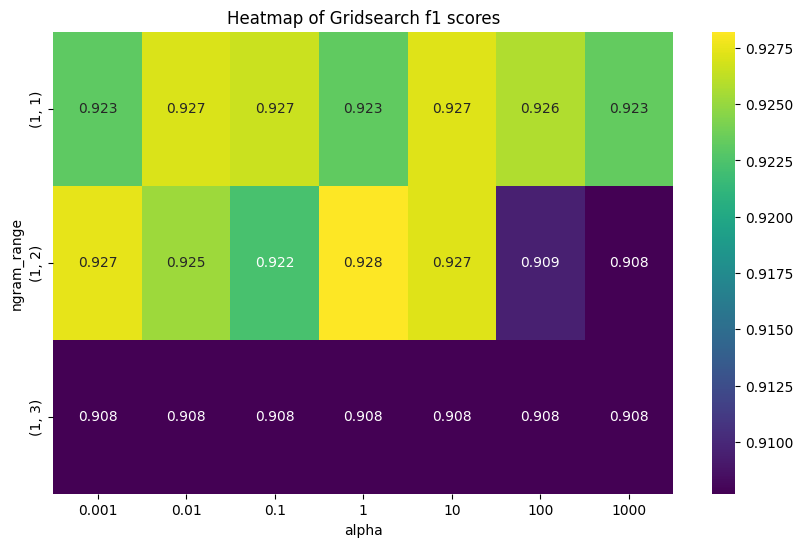

In [ ]:
plot_gridsearch_heatmap(grid, param_grid, 
                        x_param='multinomialnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range')

The highest F1 score (~0.93) is achieved when alpha=1 and ngram_range=(1,2), as also confirmed by grid.best_params_. This suggests that including bigrams (in addition to unigrams) improves the model's classification performance.

Small alpha values (0.001, 0.01, 0.1, 1) generally yield good performance.
Very large alpha values (100, 1000) lead to a slightly drop in F1 score, especially for ngram_range=(1,2), indicating over-smoothing.

The performance of (1,1) and (1,2) is relatively stable across different values of alpha (up to 10).

The lowest row corresponds to ngram_range=(1,3), and all its F1 scores are the same (0.908) regardless of the alpha value. This suggests a few key insights:
* Adding trigrams does not provide additional discriminative power for this task.
* Trigrams are inherently less frequent than unigrams or bigrams, which may lead to a sparse feature space Naïve Bayes (especially with TF-IDF) tends to downweight rare features, making the contribution of trigrams negligible.
* Since all values in this row are identical, it means that changing alpha does not affect performance when using trigrams. This suggests that the smoothing parameter has little to no influence when most of the feature space consists of higher-order n-grams.
* Using trigrams is unnecessary for this classification task — it does not improve performance and only adds computational complexity. Feature selection should prioritize unigrams and bigrams, as they show meaningful variation and achieve higher F1 scores.

### **Predicting sentiment and evaluating the model**

In [37]:
y_pred = grid.predict(X_test)

#### **Confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.75      0.39      0.51     25970
           1       0.89      0.97      0.93    127703

    accuracy                           0.87    153673
   macro avg       0.82      0.68      0.72    153673
weighted avg       0.86      0.87      0.86    153673



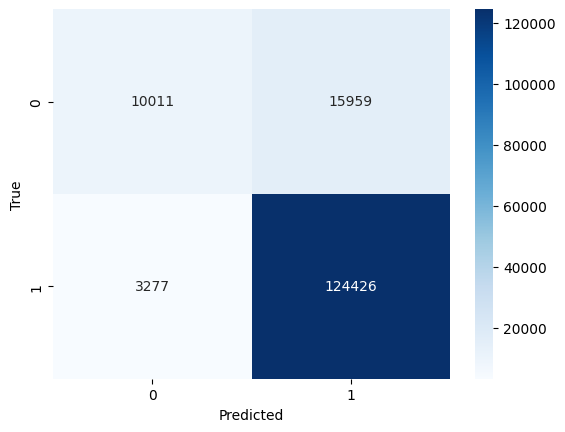

In [38]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the classification report, we can see that the model has a high precision and recall for positive reviews, but a lower precision and recall for negative reviews. This is likely due to the class imbalance in the dataset, as the model is biased towards predicting positive reviews amd better learns the patterns of positive reviews. 

**Performance Insights form the confusion matrix**
- *High True Positives:* The model is great at predicting positive reviews
- *High False Positives:* There are quite a few cases where negative sentiment was wrongly predicted as positive (15959). This could be because the model is biased towards positive sentiment.
- *Low False Negatives:* Only a small number of positive sentiments were misclassified as negative. This is good as it shows that the model is not missing many positive reviews.
- *Low True Negatives:* The model struggles more with correctly identifying negative sentiment.

#### **Precision-recall curve evaluation**

Since the dataset is imbalanced, we use the precision-recall (PR) curve to evaluate the model. The PR curve illustrates the trade-off between precision and recall at different classification thresholds, focusing on the minority class (negative reviews). By analyzing the PR curve, we can determine the optimal threshold for our model.

##### **Precision-recall curve for majority class**

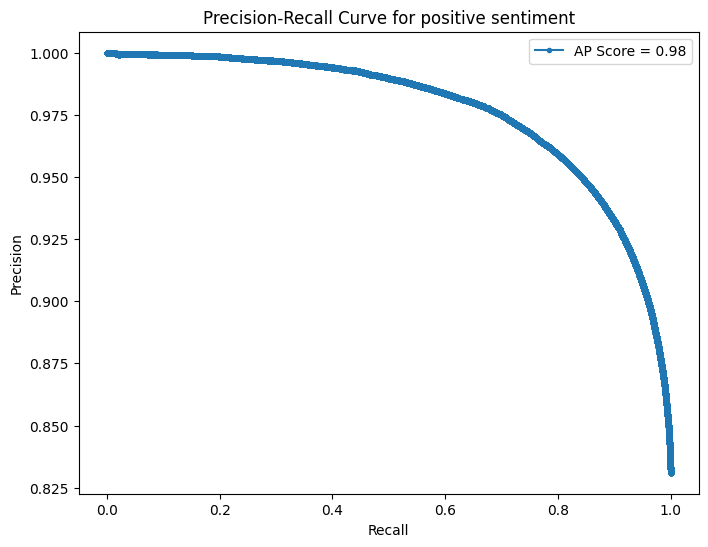

In [ ]:
y_scores_pos = grid.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos, 'positive')

The PR curve for the majority class (positive reviews) indicates that:
* Precision remains close to 1.0 for a large portion of the recall range, meaning the model is highly confident when predicting positive reviews.
* Even at high recall levels, precision only drops slightly, suggesting that the model rarely misclassifies non-positive reviews as positive.
* A very high average precision (AP) score of 0.98 suggests the model performs exceptionally well on the majority class. This is expected because the dataset is imbalanced in favor of positive reviews, making it easier for the model to correctly classify them.

However since the curve is based on the majority class, it is not as informative. Therefor we will also look at the PR curve for the minority class.

##### **Precision-recall curve for minority class**

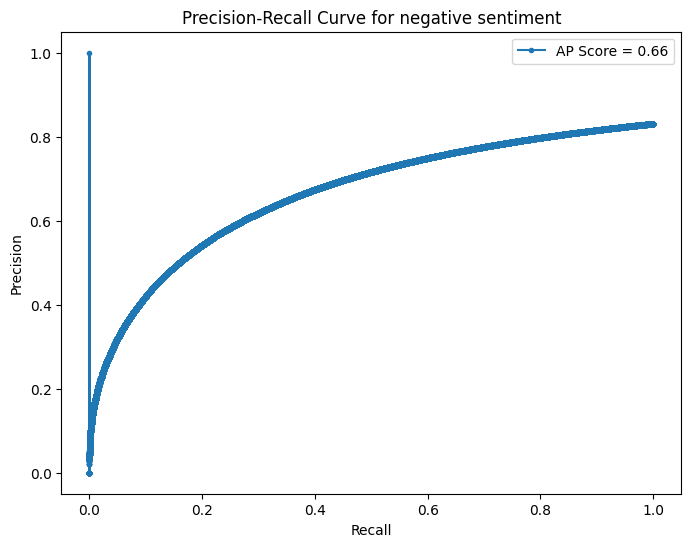

In [ ]:
y_scores_neg = grid.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg, 'negative')

The PR curve for the  minority class (negative reviews) indicates that:
* An AP score of 0.66 suggests moderate performance in identifying negative reviews. Given the class imbalance, this is a reasonable score
* The sharp drop at the beginning indicates that when the recall is very low (i.e., the model is very conservative in predicting negative reviews), precision is nearly perfect. However, as recall increases slightly, precision drops quickly, meaning the model struggles to balance identifying negative reviews while maintaining precision.
* The curve shows a steep decline in precision as recall increases, indicating that the model is not very good at identifying negative reviews.

Based on both PR curves we can say that the model is excellent at predicting positive reviews but struggles more with negatives. Since most reviews are positive, the model may have learned to favor positive predictions, possibly at the expense of recall for negative reviews.

#### **Visualizing the top features that are most indicative of positive and negative sentiment of reviews**

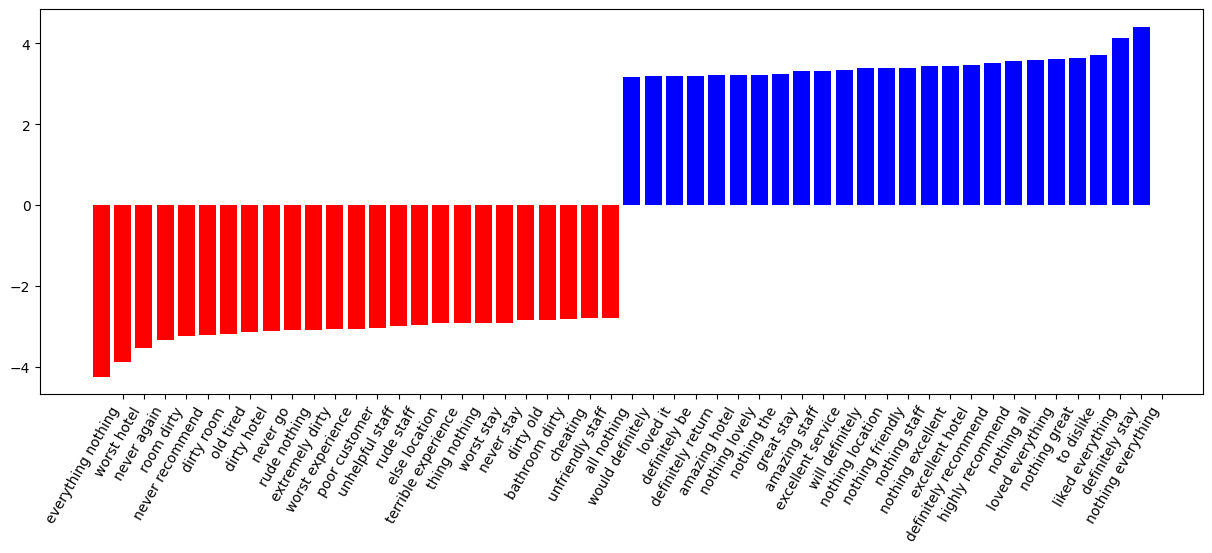

In [ ]:
visualize_top_features(grid, X_train, classifier_step="multinomialnb")

The visualization show the top 20 features that are most indicative of positive and negative reviews. The features with the highest coefficient values are most indicative of positive reviews, while the features with the lowest coefficient values are most indicative of negative reviews.

After exploring the dataset further we have discovered that if a review starts with a negation such as "nothing" the reviews are usually positive. Our model seems to understand this well, as we can see many of the bigrams on the right side of the visualization are negations, for example "nothing all" - this stems from reviews like "Nothing all good" which is a review written in the Negative_Review column. In addition we have the bigram "nothing location" that stems from the review "Nothing location was perfect" which is also a positive review, written in the Negative_Review column because the person means that nothing is negative and that the location was perfect. We also have the bigram "nothing bed", "nothing perfect", "nothing lovely", "nothing friendly", and "nothing excellent" and so on. All of these bigrams stems from reviews in the Negative_Review column, and therefore the model has learned that if a review starts with "nothing" it is usually a positive review.

One issue with our model is that as we can see "everything nothing" is considered the most indicative of a negative review. This is incorrect however, as the reviews that contain this bigram usually go something like this: "I liked everything Nothing to complain about". This is actually a positive review, but the model has learned that if a review starts with "nothing" it is usually a positive review, and therefore it has learned that "everything nothing" is indicative of a negative review. 

### **Brief summary of the Multinomial NB Model**

**What the Model is Good At on this data:**
* Classifying Positive Reviews → High precision and recall for positive sentiment.
* Confidence in Predictions → Maintains high precision even at high recall levels (AP Score = 0.98).
* Learning Common Patterns → Correctly identifies that "nothing" at the start of a negative review often indicates a positive review as it is a negation word.

**What the Model Struggles With:**
* Detecting Negative Reviews → Lower precision and recall for negative sentiment (AP Score = 0.66).
* False Positives → Frequently misclassifies negative reviews as positive (10,514 cases).

## **Complement NB Model**

The next model we will use is Complement Naive Bayes with TF-IDF vectorizer. Complement Naive Bayes is a variant of the Naive Bayes algorithm that is particularly well-suited for imbalanced datasets. With this model we hope to see a signitficant improvement in the classification of negative reviews compared to the Multinomial NB model since Multinomial tends to be biased toward the majority class in imbalanced datasets which we saw in our evaluation of the Multinomial NB model in the previous section.
The ComplementNB is designed to handle imbalanced data by adjusting the weights of features that are overrepresented in the majority class. This makes it a good choice for our dataset, which has a large number of positive reviews and a smaller number of negative reviews.

### **Creating pipeline, Vectorizer and Gridsearch with cross validation**

We use the same vectorizer and gridsearch parameters as in the Multinomial NB model, as they are suitable for text classification tasks and have been optimized for our dataset. We also use the same pipeline structure to ensure consistency and efficiency in the model training process.

In [34]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), ComplementNB())

param_grid = {'complementnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='f1', refit=True, n_jobs=-1)

grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best estimator: {}".format(grid.best_estimator_))

Best parameters: {'complementnb__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 3)}
Best cross-validation score: 0.92
Best estimator: Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=1))])


### **Heat map of mean cross-validation f1 score as a function of the parameters ngram_range and alpha**

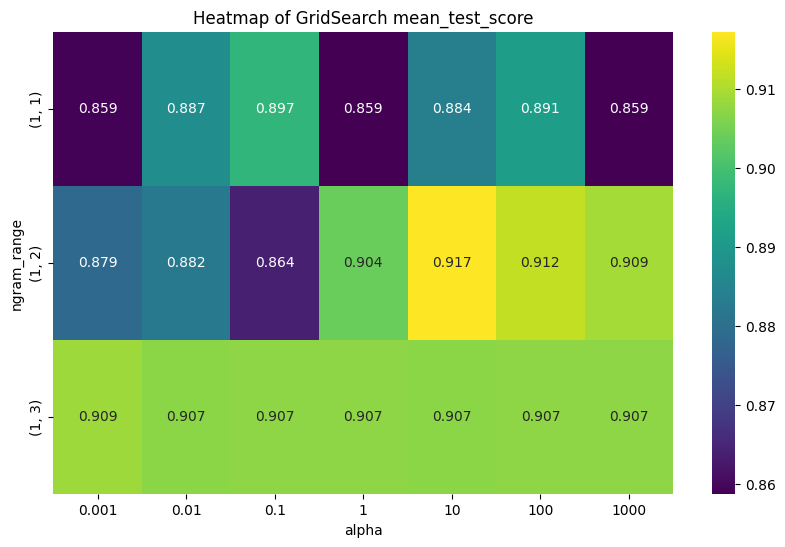

In [35]:
plot_gridsearch_heatmap(grid, param_grid, 
                        x_param='complementnb__alpha', 
                        y_param='tfidfvectorizer__ngram_range')

From the heatmap above we can see that the best f1-score is obtained with an ngram range at (1,2) and alpha at 10. This matches well with our findings in the heatmap from MultionmialNB, as it suggests that including bigrams (in addition to unigrams) improves the model's classification performance.

As in the case with MultinomialNB, the lowest row corresponding to ngram range (1,3), suggests that using trigrams is unecessary for this task, because it does not improve performance (rather it worsens it), and is computationally expensive. 

### **Predicting sentiment and evaluating the model**

In [36]:
y_pred = grid.predict(X_test)

#### **Confusion matrix and classification report**

              precision    recall  f1-score   support

           0       0.59      0.68      0.63     25970
           1       0.93      0.90      0.92    127703

    accuracy                           0.86    153673
   macro avg       0.76      0.79      0.77    153673
weighted avg       0.87      0.86      0.87    153673



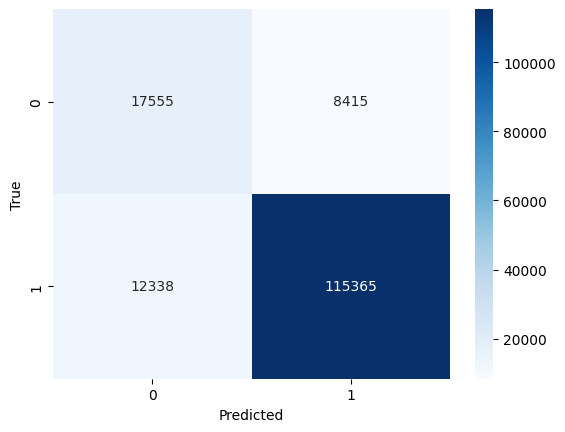

In [37]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix above we can see the amount of true positives and true negatives. As with MultinomialNB, the model is good at predicting positive reviews, as it has a high amount of true positives, but worse at predicting negative reviews. The difference between the two models is most apparent here, as ComplementNB has about half the amount of false positives as MultinomialNB. This is good because it means that the model is less biased towards positive reviews. The drawback here is that we miss out on almost 10 000 true positives compared to MultinomialNB. Another difference in the confusion matrix is that the amount of false negatives is almost 4x as high in ComplementNB as in MultinomialNB, with an increase in true negatives of about 7 000. 

The conclusion here is that ComplementNB has a much more balanced approach to the dataset, and can successfully downweigh the absurd amount of positive reviews to account for the small amount of negative reviews we have at our disposal. This gives a much more balanced model, and a more generalized model that can be used on other datasets as well.

#### **Precision-recall curve evaluation**

##### **Precision-recall curve for majority and minority**

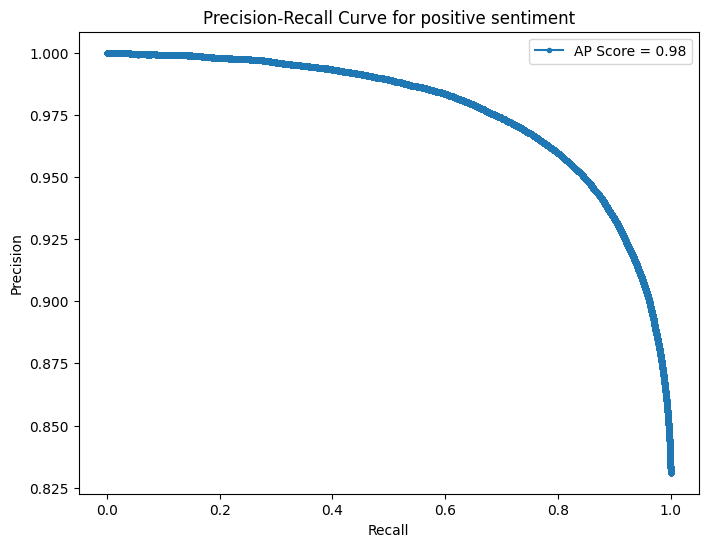

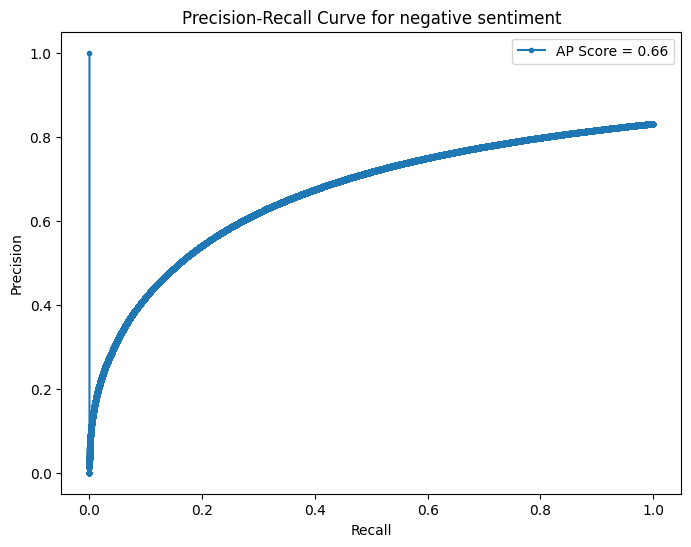

In [38]:
# Positive sentiment
y_scores_pos = grid.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos, 'positive')

# Negative sentiment
y_scores_neg = grid.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg, 'negative')

What we can observe from the two PR-curves is that the for positive sentiments, ComplementNB is very good and the relationship between precision and recall is a natural curve, e.g. that lower precision gives higher recall and vice versa. The important thing of note here is that both precision and recall can reach 100%, at the expense of the other. The AP-score of 0.98 is very good, and shows that the model is very good at predicting positive reviews, which is not surprising. 

As for the PR-curve for the minority class (negative sentiment), it performs significantly worse, with an AP-score of 0.66. We can observe from the curve that when recall is at 0, precision is at 0 too. As precision / recall increases, the other value increases as well, to a maximum of 100% for recall and around 80% for precision. This is a decent result, as it shows that even though there is an extreme overweight of positive reviews, the model can still predict negative reviews with a decent accuracy. 

#### **Visualizing the top features that are most indicative of positive and negative sentiment of reviews**

Features with lowest TF-IDF:
['by this point' 'on first arrival' 'we decided that' 'eventually allowed'
 'first arrival' 'in the ticket' 'they will check' 'incident to the'
 'off even though' 'leave message' 'also mentioned that' 'not long after'
 'but instead it' 'at me in' 'the above issue' 'the past in'
 'our stay upon' 'lady said that' 'all these are' 'them again and']

Features with highest TF-IDF:
['friendly' 'place' 'con' 'nathing' 'think' 'pat' 'regular' 'cleanliness'
 'all' 'would' 'balcony' 'bad' 'nothing' 'convenient' 'aircon'
 'convenience' 'got' 'perfekt' 'dirty' 'my']


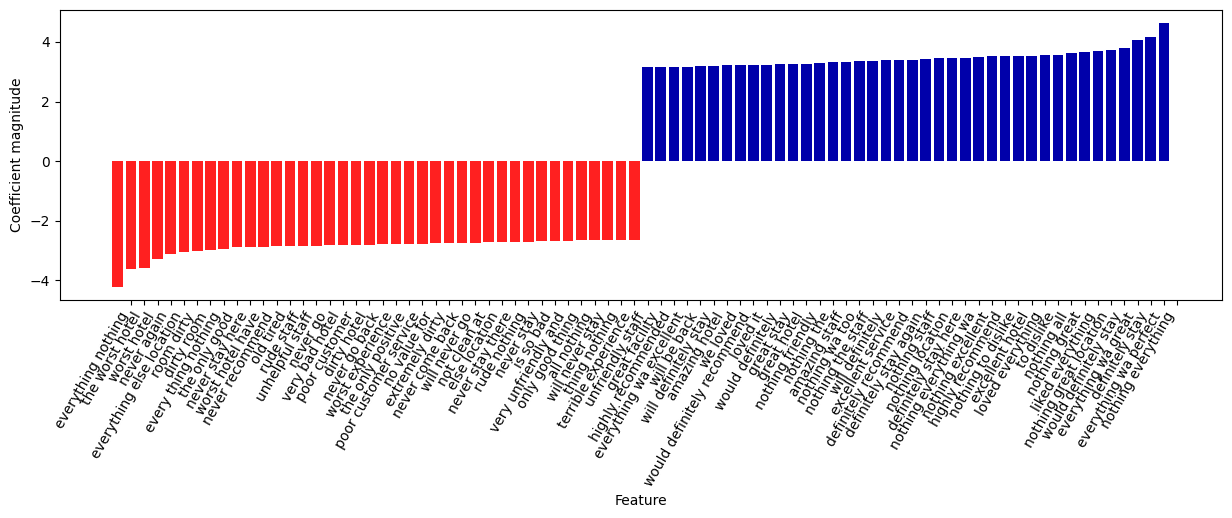

In [39]:
visualize_top_features(grid, X_train, classifier_step="complementnb")

The visualization reflects the top 20 features that are most indicative of positive and negative reviews from the best ComplementNB model. We see a lot of the same bigrams as in the MultinomialNB model, and this model also includes trigrams. The model also understands the negation scenario described in Multinomial section. Apart from this, there is not much more to say than already described in the MultinomialNB section.

### **Brief summary of the Complement NB Model and comparison to Multinomial NB**

MultinomialNB and ComplementNB, although being based off the same algorithm perform a bit differently on our dataset. The main difference between the two models is that ComplementNB is much better at predicting negative reviews, while insignificantly better at predicting positive reviews. This is due to the fact that ComplementNB is designed to handle imbalanced datasets, and can adjust the weights of features that are overrepresented in the majority class. This is a good choice for our dataset, which has a large number of positive reviews and a smaller number of negative reviews. Thus we can conclude that while both models are excellent at predicting positive reviews, ComplementNB has a better approach to sentiment analysis as it also is decent at predicting negative reviews. 

## **Tree based model (XGBoost)**


### **Creating a benchmark model**

We start with a "base learner" model, which is a simple XGBoost model with default hyperparameters. This gradient boosting classifier model will serve as a benchmark for the more advanced models we will build later. The base model build 100 trees during training and the model uses a histogram-based method for building the trees, which is fast for large datasets like ours. Although allowing the model to build more trees can potentially improve accuracy, it may also lead to overfitting. Therefore, we choose 100 trees as a starting point for our benchmark model to allow it to capture the underlying patterns in the data without overfitting. 

In [40]:
vectorizer = TfidfVectorizer(min_df = 5, max_df=0.8)

X_train_tfidf = vectorizer.fit_transform(X_train)

xgb_clf = XGBClassifier(n_estimators = 100, tree_method='hist', n_jobs=-1)

xgb_clf.fit(X_train_tfidf, y_train)

y_pred = xgb_clf.predict(vectorizer.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.41      0.53     25970
           1       0.89      0.97      0.93    127703

    accuracy                           0.88    153673
   macro avg       0.82      0.69      0.73    153673
weighted avg       0.87      0.88      0.86    153673



From the classification report, we can observe that with a relatively simple model, with a small number of trees (100) we still get a pretty good result. A weighted average F1-score of 0.86 indicates that the model is performing well overall. As for the other models this XGBoost model performs very well for class 1 (high recall, precision, and F1-score), but it struggles with class 0 (low recall), meaning it's not identifying all of the class 0 instances correctly. This trade-off highlights the need to adjust the model further. XGBoost is a model that is extremely sensitive to hyperparameters, thus we will move forward with tuning the hyperparameters to get the best possible result.

### **Visualizing important words influencing the models predictions**

In [41]:
importances = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': xgb_clf.feature_importances_
})

print(importances.shape[0])

importances = importances.sort_values(by='Importance', ascending=False)
importances.head(10)

15975


,Feature,Importance
5437,excellent,0.018471
10512,perfect,0.013607
4519,dirty,0.013279
5697,fantastic,0.011675
1679,bad,0.011274
6618,great,0.011061
9564,never,0.010403
1103,amazing,0.010366
8551,lovely,0.010011
3325,comfortable,0.009409


<Axes: xlabel='Feature'>

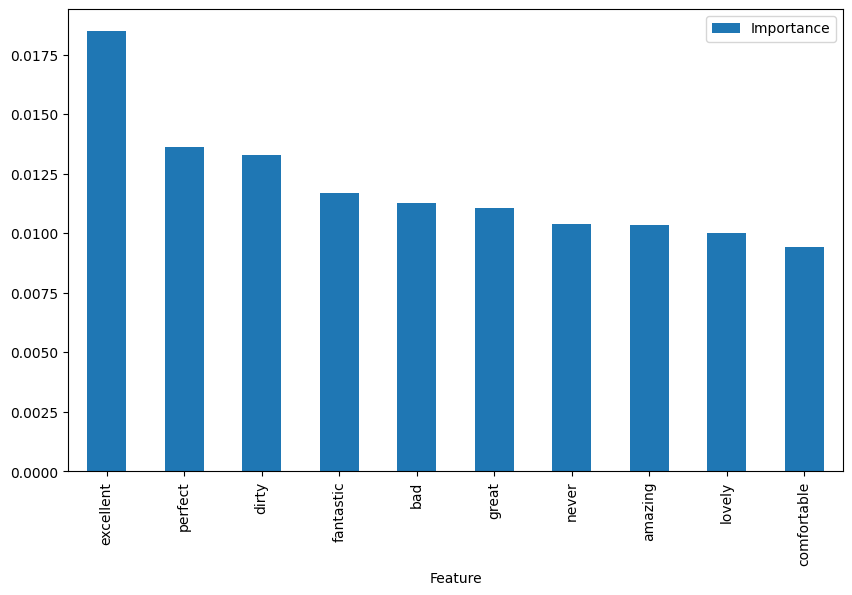

In [42]:
importances[:10].plot.bar(x='Feature', y='Importance', figsize=(10, 6))

The bar plot above shows the top 10 most important words influencing the model's predictions. The words shown here are what we typically expect to be important sentiment indicators in text. Since XGBoost looks at many features/words (15975) and not just a few, the importance is spread out, and no single feature dominates the importance scale. This leads to relatively small importance values for each individual word, even for those with high influence, such as 'excellent' and 'perfect'. However, when viewed in the context of all the features, these words still have a significant impact on the model’s decisions.

### **Hyperparameter tuning**

Due to the extensive parameters of the model and the sheer size of our dataset, we opt for a randomized search over a grid search. This is because a grid search would take too long to run, and a randomized search is much more efficient for such a large dataset.

As we did when building the other models, we also here create a pipeline including a TF-IDF vectorizer. The parameters chosen for the vectorizer are the same as in the previous models, ensuring that only words that appear in at least 5 documents are considered, words that appear in more than 80% of the reviews are excluded. The vectorizer can also capture both unigrams and bigrams because some word combinations can provide more context and sentiment information than individual words. We then pass the transformed data to an XGBoost classifier, which is the model we are tuning. The objective parameter specifies that we are solving a binary classification problem, where the model will output probabilities (logistic regression output) for class 0 or class 1. The model uses a histogram-based method for building the trees, which is fast for large datasets like ours. Evaluation metric is set to F1-score, because its useful in imbalanced classification tasks.

The parameter grid for the model’s hyperparameters includes the most important parameters that can significantly affect the model’s performance. We use a wide range of values for each parameter to ensure that we explore a large portion of the hyperparameter space. RandomizedSearchCV will randomly sample combinations of these values and evaluate the model's performance using cross-validation. This process allows us to find the best combination of hyperparameters without exhaustively searching through all possible combinations, which would be computationally expensive and time-consuming.

In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, ngram_range = (1,2)), XGBClassifier(objective='binary:logistic', tree_method='hist', n_jobs=-1, eval_metric='logloss'))

param_dist = {'xgbclassifier__eta': [0.01, 0.05, 0.1, 0.2],
               'xgbclassifier__max_depth': [3,5,7,9,12], 
               'xgbclassifier__n_estimators': [100, 250, 500, 750, 1000], 
               'xgbclassifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
               'xgbclassifier__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
               'xgbclassifier__lambda' : [0,1,2,5, 10] }

f1_scorer = make_scorer(f1_score, average='macro')

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = RandomizedSearchCV(pipe, param_dist, cv=kfold, scoring=f1_scorer, refit=True, n_jobs=7, n_iter=10, verbose=1) # Running with 7 out of 8 cores

grid.fit(X_train, y_train)

print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation F1-score: {:.2f}".format(grid.best_score_))
print("Best estimator/model: {}".format(grid.best_estimator_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


### **Visualize the relationship between 'max_depth' and the mean test F1 score**


In [ ]:
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 6))
plt.scatter(results['param_xgbclassifier_max_depth'], results['mean_test_score'])
plt.xlabel('Max Depth')
plt.ylabel('Mean F1 Score')
plt.title('Hyperparameter Search: Max Depth vs. F1 Score')
plt.show()

kommenter det vi ser

### **Making predictions using the best model and evaluating the model**

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

kommenter confusion matrix of classification report

### **Precision-Recall Curves for Positive and Negative Sentiments**

In [ ]:
# Positive sentiment
y_scores_pos = grid.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_pos, 'positive')

# Negative sentiment
y_scores_neg = grid.predict_proba(X_test)[:, 0]
plot_precision_recall_curve(y_test, y_scores_neg, 'negative')

kommenter PR kurvene

## **LSTM Model**

### **Preprocessing the data for the LSTM model**

#### **Tokenizing and padding**

Here we prepare the reviews for the LSTM model by tokenizing the text and padding the sequences. The parameter num_words is set to 5000 to limits the tokenizer to only consider the top 5000 most frequent words to help reduce the vocabulary size and improve the efficiency of the model. Words that are not among these 5000 words are represented by "OOV". texts_to_sequences converts each review into a sequence of integers, where each word in the text is replaced with its corresponding integer value from the vocabulary. 

In [35]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Next, we use padding to ensure that all sequences have the same length and truncate longer sequences to the specified maximum length. This is necessary because the LSTM model requires fixed-length inputs to process them correctly. 

In [36]:
max_length_train = max([len(review) for review in X_train_seq])
max_length_test = max([len(review) for review in X_test_seq])
max_length = max(max_length_train, max_length_test)
print(max_length)

753


As we can see, the model will receive inputs that all have a consistent size of 753 tokens.

To better understand how many reviews are really long and how many are short we plot a histogram of the review lengths. If most of the sequences are significantly shorter than 753, then it might be worth considering truncating some of them further (i.e., reducing maxlen) to make the model more efficient.

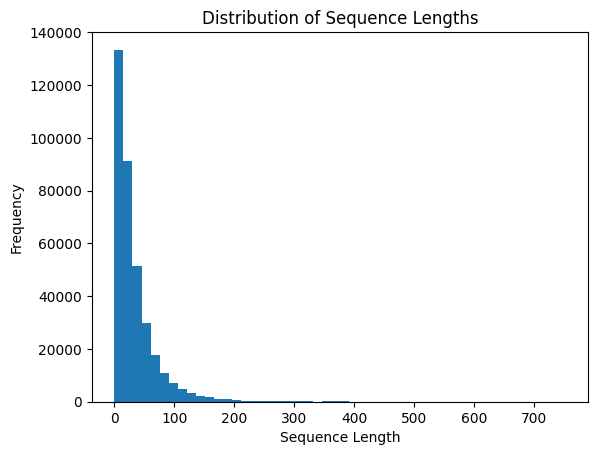

In [37]:
# Check distribution of review length
seq_lengths = [len(review) for review in X_train_seq]
plt.hist(seq_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [38]:
# print the distribution of review length
print(pd.Series(seq_lengths).describe())

count    358570.000000
mean         33.883512
std          38.677736
min           0.000000
25%          11.000000
50%          22.000000
75%          43.000000
max         753.000000
dtype: float64


From the histogram and the distribution above, we can see that there is virtually no good reason to use the max length. Arund 75% of reviews are below 43 tokens long, and from the histogram we can see that there is very little information to be gained from reviews longer than around 150 tokens. Thus we adjust the max length to 150. This ensures that the model can run more efficiently, and that we do not waste resources on padding sequences that are not needed.        

In [39]:
max_length = 150

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [40]:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[  18  273   29 ...    2   67 1496]
 [   9  131   51 ...    0    0    0]
 [ 437 2440  325 ...    0    0    0]
 ...
 [ 124   39   25 ...    0    0    0]
 [   2   14   15 ...    0    0    0]
 [   9   51    7 ...    0    0    0]]

X_test_padded:
[[   1   74  110 ...    0    0    0]
 [   7  128  908 ...    0    0    0]
 [   2    7   50 ...    0    0    0]
 ...
 [   5  861   20 ...    0    0    0]
 [  31   10 4812 ...    0    0    0]
 [   2   57  125 ...    0    0    0]]


### **Creating the LSTM model**

The first layer of our LSTM model is an embedding layer which is used to transform the the text tokens into dense vector representations before feeding them into the LSTM layer. The input dimension of the embedding layer is set to 5000 which is the number of unique words in our vocabulary as spesified in the tokenizer above. The output dimension of 128 means that each word will be represented by a 128-dimensional vector. The input length is set to maxlength (150) which is the maximum length of the sequences after padding. The next layer of the model is a dropout layer which is used to prevent overfitting. The dense layer is used to output the final prediction and we use the sigmoid activation because it outputs a value between 0 and 1 which is suitable for our classification problem.

Next we compile the model using the binary crossentropy loss function which is suitable for binary classification problems. We use the adam optimizer which is a popular optimizer for deep learning models. We also use accuracy as the metric to evaluate the model. 

We add early stopping to prevent overfitting and to stop the training process when the model's performance on the validation set stops improving. We also reduce the learning rate when the model's performance on the validation set stops improving. This can help the model converge faster and avoid getting stuck in local minima.

In [42]:
model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

model.build(input_shape=(None, max_length))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

### **Training the LSTM model**

In [43]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/10
5603/5603 ━━━━━━━━━━━━━━━━━━━━ 748s 133ms/step - accuracy: 0.8386 - loss: 0.4181 - val_accuracy: 0.8897 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 2/10
5603/5603 ━━━━━━━━━━━━━━━━━━━━ 671s 120ms/step - accuracy: 0.8927 - loss: 0.2531 - val_accuracy: 0.8946 - val_loss: 0.2465 - learning_rate: 0.0010
Epoch 3/10
5603/5603 ━━━━━━━━━━━━━━━━━━━━ 677s 121ms/step - accuracy: 0.9016 - loss: 0.2330 - val_accuracy: 0.8949 - val_loss: 0.2452 - learning_rate: 0.0010
Epoch 4/10
5603/5603 ━━━━━━━━━━━━━━━━━━━━ 675s 120ms/step - accuracy: 0.9066 - loss: 0.2218 - val_accuracy: 0.8946 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 5/10
5603/5603 ━━━━━━━━━━━━━━━━━━━━ 680s 121ms/step - accuracy: 0.9126 - loss: 0.2089 - val_accuracy: 0.8923 - val_loss: 0.2517 - learning_rate: 0.0010


### **Predicting sentiment**

In [ ]:
y_pred = model.predict(X_test_padded)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

### **Evaluating the LSTM model and plotting accuracy and loss**

4803/4803 ━━━━━━━━━━━━━━━━━━━━ 162s 34ms/step - accuracy: 0.8913 - loss: 0.2534
Test accuracy: 0.8922972679138184


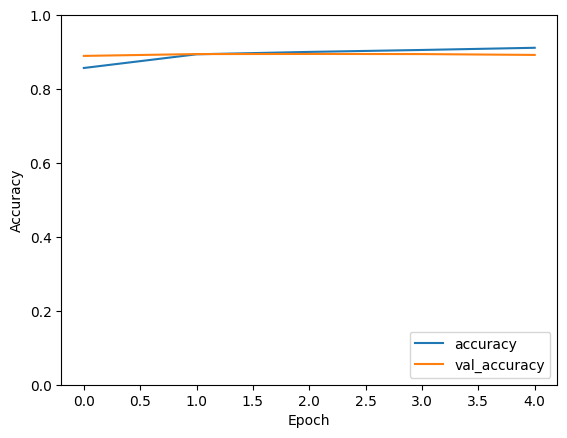

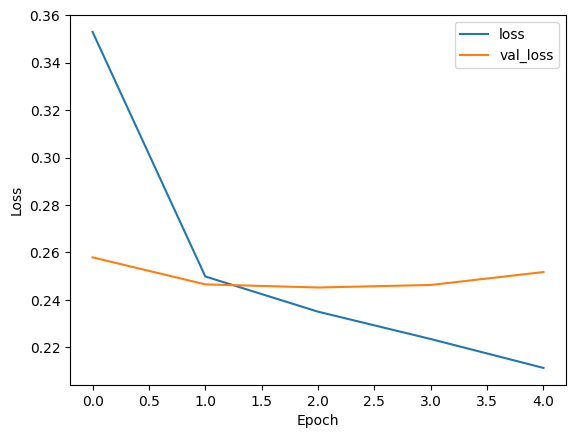

In [ ]:
# test the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print('Test accuracy:', accuracy)
print('Test loss:', loss)

# plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

The visualization above shows that the training and validation accuracy remains relatively stable throughout the training process and the different epochs. 
The visualization of loss function shows that the training loss decreases rapidly from epoch 0 to 1, and from epoch 1 to 4 it decreases more slowly. This indicates that the model is learning and improving its ability to make accurate predictions. The validation loss however remains relatively stable throughout the training process, which is a good sign that the model is not overfitting to the training data.

In [46]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'y_pred' is not defined